In [1]:
library(tidyverse)
library(Matrix)
library(patchwork)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [2]:
options(repr.plot.width=12, repr.plot.height=6.75)

The first-stage results are generated in `compute_ideal_points.R`

In [3]:
load("../data/correspondence_analysis.rdata")

In [4]:
str(res, max.level=1)

List of 15
 $ sv        : num [1:590] 0.798 0.576 0.474 0.429 0.389 ...
 $ nd        : num 3
 $ rownames  : chr [1:166704] "100003044" "100005598" "100006314" "10000682" ...
 $ rowmass   : num [1:166704] 3.70e-06 1.23e-05 1.07e-05 4.11e-06 2.88e-06 ...
 $ rowdist   : num [1:166704] 1.79 5.78 4.75 1.55 1.61 ...
 $ rowinertia: num [1:166704] 1.19e-05 4.11e-04 2.41e-04 9.90e-06 7.48e-06 ...
 $ rowcoord  : num [1:166704, 1:3] -0.725 -0.547 2.73 -0.571 -0.501 ...
 $ rowsup    : logi(0) 
 $ colnames  : chr [1:1893] "MH11614657" "MH11614863" "MH11615124" "MH11615431" ...
 $ colmass   : num [1:1893] 0.000107 0.000144 0.000143 0.012204 0.000458 ...
 $ coldist   : num [1:1893] 19.74 17.58 16.81 2.04 8.12 ...
 $ colinertia: num [1:1893] 0.0418 0.0446 0.0403 0.0507 0.0302 ...
 $ colcoord  : num [1:1893, 1:3] 1.449 0.829 0.339 -0.636 -0.213 ...
 $ colsup    : int [1:1302] 589 590 591 592 593 594 595 596 597 598 ...
 $ call      : language CA(obj = mat, nd = 3, supcol = non_politicians)
 - attr(*, "

In [5]:
elites <- read_tsv('../data/elites_combined_v2.tsv', col_types = 'ccciiiiiiiii')
head(elites, 2)

meta_id,user_id,screen_name,moc_117,moc_116,pundit,covid_elite,president,media,candidate,governor,official
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
MS11794659,21111098,SenShelby,1,1,0,0,0,0,0,0,0
MS11749703,19726613,SenatorCollins,1,1,0,0,0,0,1,0,0


In [6]:
elites$meta_id[1:10]

[1] "MS11794659" "MS11749703" "MS11749308" "MS11749300" "MS11742102"
 [6] "MS11742102" "MS11742101" "MS11742101" "MS11742100" "MS11742100"

The first dimension of the ideal points, ($\phi$ in the original paper) contain most of the explanatory power, but it is worth investigating to see if the second dimension is also interesting.

In [7]:
phi <- scale(res$colcoord[,1])
phi_2 <- scale(res$colcoord[,2])

names(phi) <- res$colnames
names(phi_2) <- res$colnames

In [8]:
elites$phi <-phi[elites$meta_id]
elites$phi_2 <-phi_2[elites$meta_id]

In [9]:
mat <- readMM("../data/panel_elites_mat.mtx")

colnames(mat) <- readLines("../data/panel_elites_mat_colnames.txt")
rownames(mat) <- readLines("../data/panel_elites_mat_rownames.txt")

In [10]:
elites$followers <- colSums(mat)[elites$meta_id]

As a sanity check, compare the estimates to NOMINATE scores. The input data is the 117th Congress, but we use the NOMINATE scores for the 116th Congress and accept the missing values because the earlier scores should be more stable.

In [11]:
elites$voteview_id <- str_match(elites$meta_id, "M[SH]117(\\d+)")[,2]
dwnom <- read_csv("../data/HS116_members.csv") %>% select(nominate_dim1, nominate_dim2, icpsr, party_code) %>% mutate(voteview_id = as.character(icpsr)) %>% select(-icpsr)
elites <- elites %>% left_join(dwnom)

elites$party <- case_when(elites$party_code == 100 ~ "Democrat", elites$party_code == 200 ~ "Republican", TRUE ~ "Independent")

Parsed with column specification:
cols(
  .default = col_double(),
  chamber = col_character(),
  state_abbrev = col_character(),
  occupancy = col_logical(),
  last_means = col_logical(),
  bioname = col_character(),
  bioguide_id = col_character(),
  died = col_logical(),
  conditional = col_logical()
)

See spec(...) for full column specifications.

Joining, by = "voteview_id"



In [12]:
elites$chamber = case_when(str_sub(elites$meta_id, 2, 2) == "S" ~ "Senate", str_sub(elites$meta_id, 2, 2) == "H" ~ "House", TRUE ~ NA_character_)

In [13]:
print(cor(elites$phi, elites$nominate_dim1, use = "pairwise.complete.obs"))
print(cor(elites$phi, elites$nominate_dim2, use = "pairwise.complete.obs"))

[1] 0.9302688
[1] 0.1602372


Warning message:
“Removed 200 rows containing missing values (geom_point).”


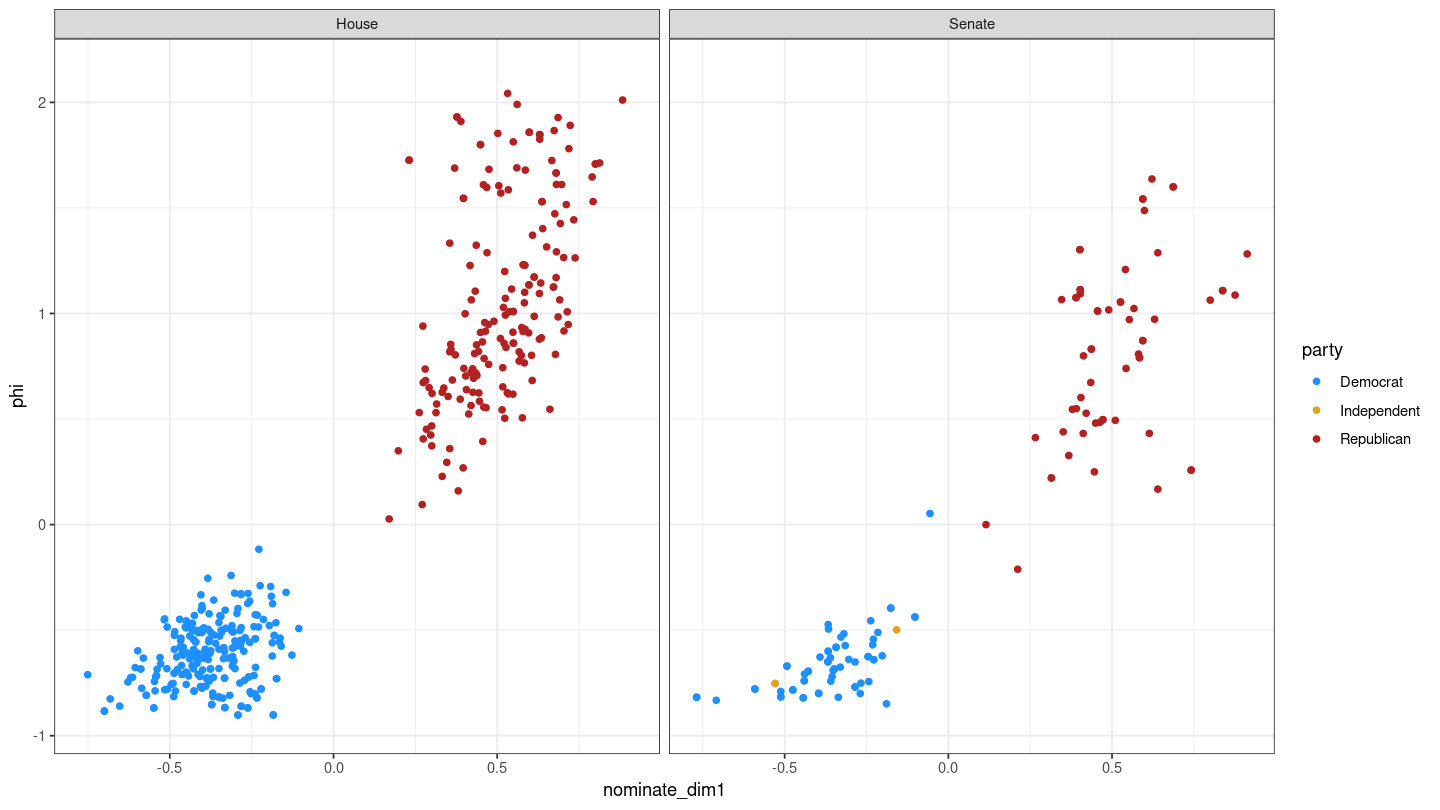

In [14]:
ggplot(elites %>% filter(!is.na(chamber)), aes(y=phi, x=nominate_dim1, color=party)) + geom_point() + theme_bw() + scale_color_manual(values=c("dodgerblue", "goldenrod", "firebrick")) + facet_wrap(vars(chamber))

The second dimension doesn't seem to have anything to do with either NOMINATE dimension.

Warning message:
“Removed 1605 rows containing missing values (geom_point).”
Warning message:
“Removed 1605 rows containing missing values (geom_point).”


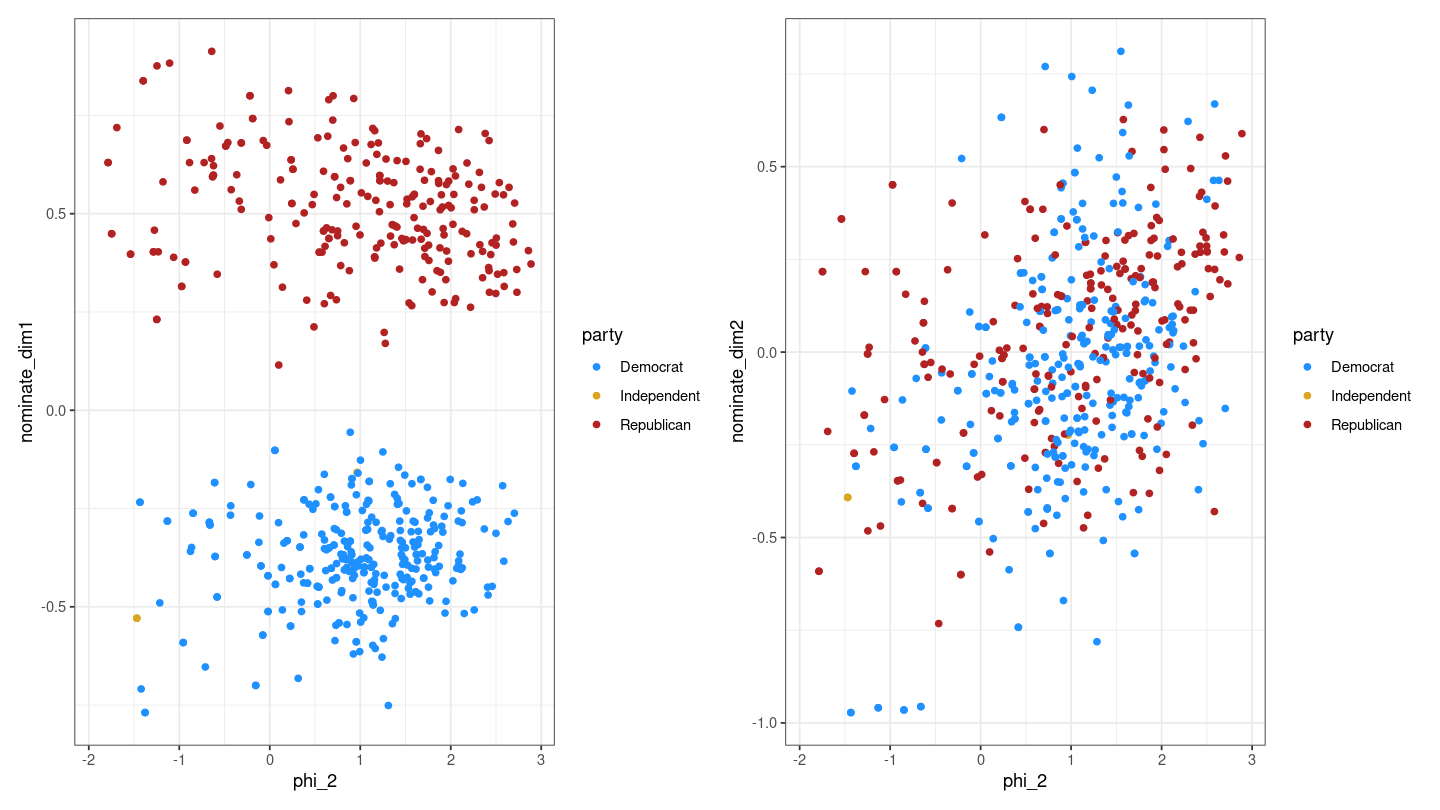

In [15]:
p1 <- ggplot(elites, aes(x=phi_2, y=nominate_dim1, color=party)) + geom_point() + theme_bw() + scale_color_manual(values=c("dodgerblue", "goldenrod", "firebrick"))
p2 <- ggplot(elites, aes(x=phi_2, y=nominate_dim2, color=party)) + geom_point() + theme_bw() + scale_color_manual(values=c("dodgerblue", "goldenrod", "firebrick"))
p1 + p2

The second dimension may have something to do with general popularity.

In [16]:
print(cor(elites$phi, elites$followers, use = "pairwise.complete.obs"))
print(cor(elites$phi_2, elites$followers, use = "pairwise.complete.obs"))

[1] -0.09703681
[1] -0.2937972


In [17]:
elites <- elites %>% mutate(
    source = case_when(
        moc_117 == 1 ~ "politician",
        moc_116 == 1 ~ "politician",
        president == 1 ~ "politician",
        official == 1 ~ "politician",
        governor == 1 ~ "politician",
        pundit == 1 ~ "pundit",
        media == 1 ~ "media",
        moc_117+moc_116+president+official+governor == 0 & candidate == 1 ~ "candidate",
        TRUE ~ "other"
    ),
    norc_list = ifelse(official+governor+candidate > 0 & moc_116+moc_117+covid_elite+pundit+president == 0, "NORC list only", "In v1 lists")
)

In [18]:
mean(elites$norc_list == "NORC list only")

[1] 0.06084533

Warning message:
“Removed 66 rows containing missing values (geom_point).”


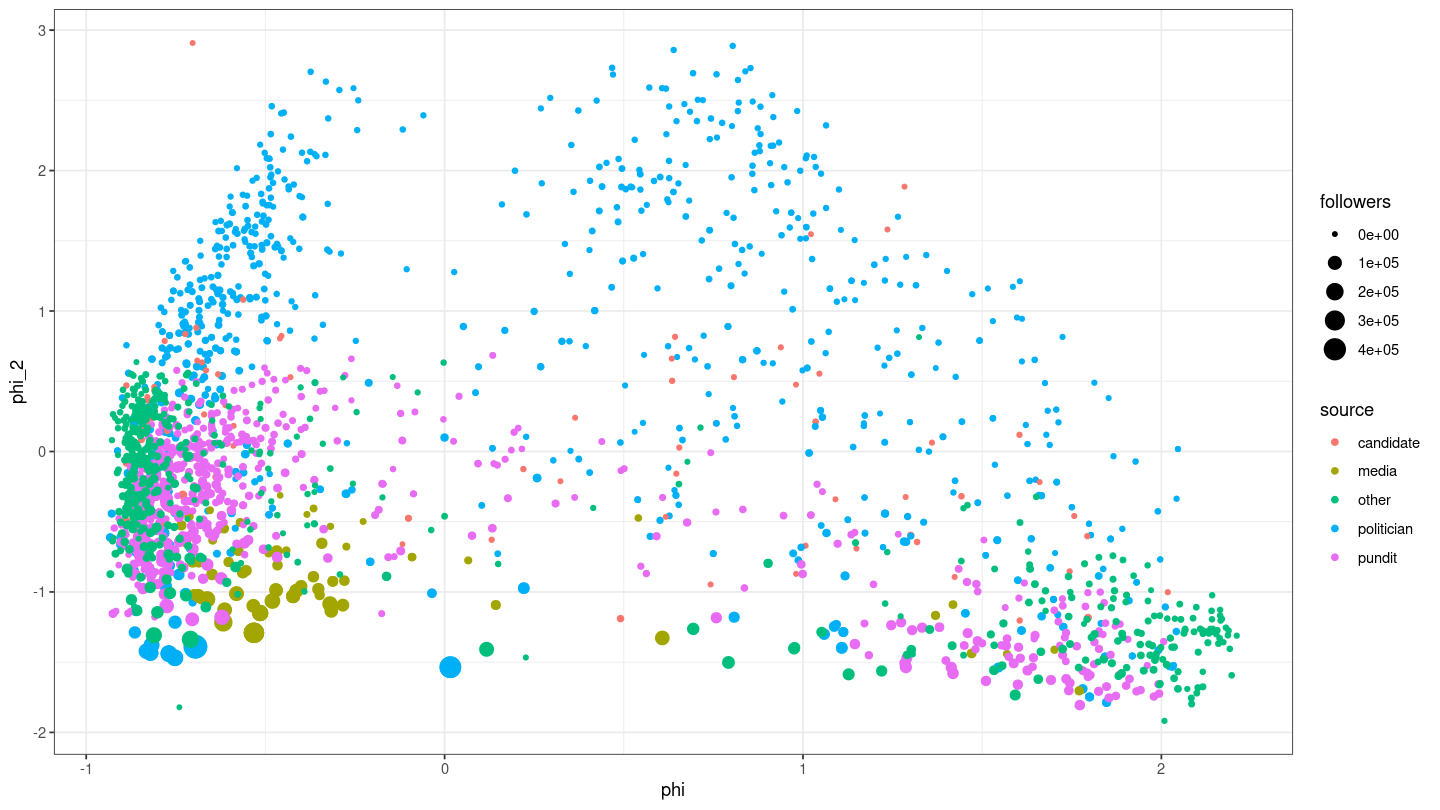

In [19]:
ggplot(elites, aes(x=phi, y=phi_2, size=followers, color=source)) + geom_point() + theme_bw()

Warning message:
“Removed 66 rows containing missing values (geom_point).”


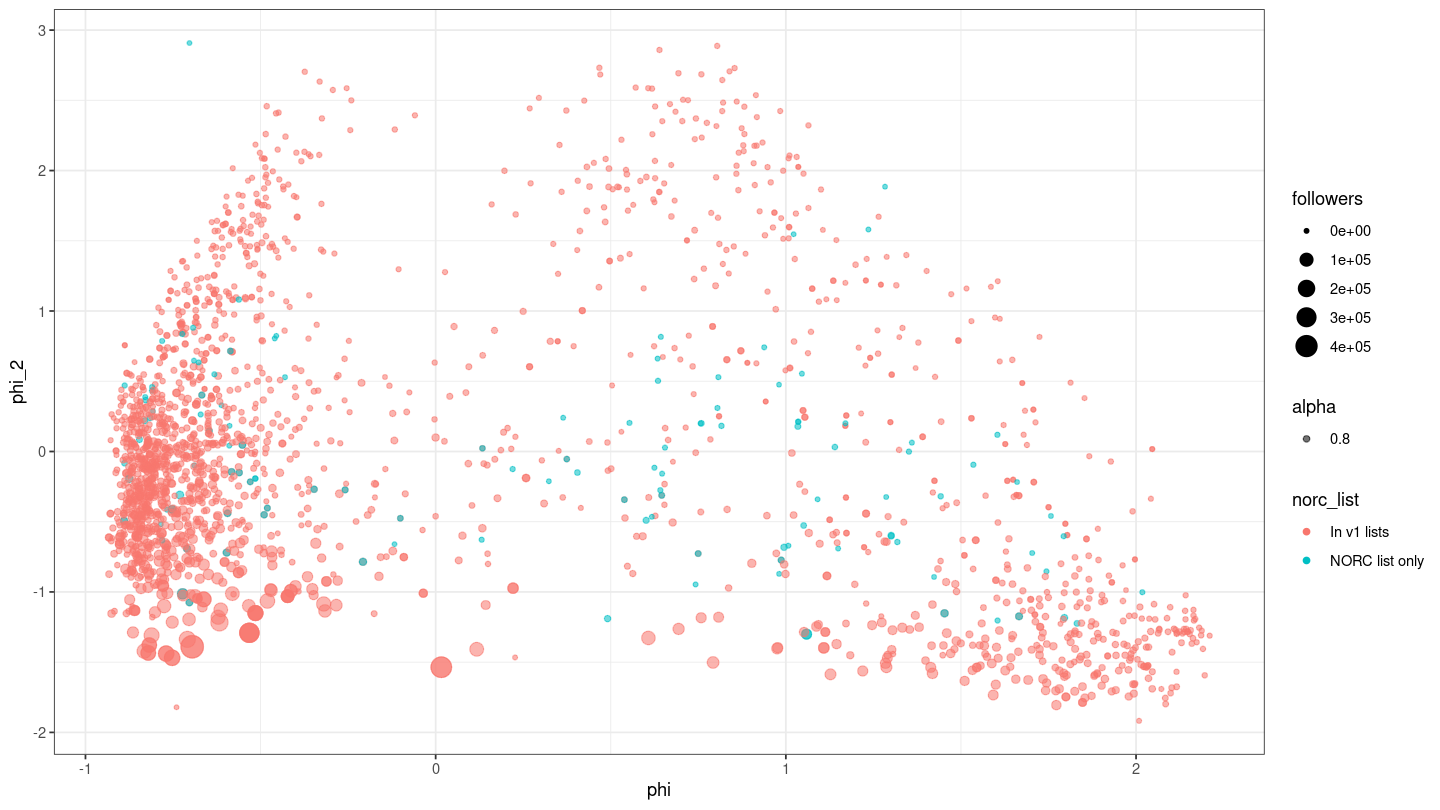

In [20]:
ggplot(elites, aes(x=phi, y=phi_2, size=followers, color=norc_list, alpha = 0.8)) + geom_point() + theme_bw()

The top/bottom 15 {MOCs,pundits,COVID elites}, by both first and second dimension.

In [21]:
elites %>% filter(moc_116 == 1 | moc_117 == 1) %>% slice_max(order_by = desc(phi), n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(pundit == 1) %>% slice_max(order_by = desc(phi), n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(covid_elite == 1) %>% slice_max(order_by = desc(phi), n = 15) %>% select(screen_name, phi, phi_2, followers)

screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
RepCori,-0.9329523,-0.612167974,8543
CoriBush,-0.9329523,-0.612167974,8543
JamaalBowmanNY,-0.9287733,-0.442257568,6021
RepBowman,-0.9287733,-0.442257568,6021
RepMondaire,-0.9126647,0.004789237,2027
MondaireJones,-0.9126647,0.004789237,2027
RepPressley,-0.9021644,-0.660866929,24226
AyannaPressley,-0.9021644,-0.660866929,24226
RepKatiePorter,-0.9014365,-0.609251887,22934


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
jaboukie,-0.9253893,-1.1545083,12347
KeeangaYamahtta,-0.9217758,-0.5450832,3708
Hbomberguy,-0.9172082,-1.1376066,2194
MalaikaJabali,-0.9093335,-0.4772507,1017
jamie_elizabeth,-0.9091559,-0.8089146,1164
BreeNewsome,-0.9032582,-0.6438790,13885
AyoCaesar,-0.9021064,-0.5256008,1127
MattLech,-0.8939982,-0.6788292,604
leslieleeiii,-0.8920141,-0.5978717,760


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
CoriBush,-0.9329523,-0.61216797,8543
nkjemisin,-0.9325775,-0.87345896,6503
lmauricecpr,-0.9281238,0.08033098,330
Imani_Barbarin,-0.9263315,-0.63734471,2157
forwardarc,-0.9252198,0.26461599,720
mqmqqmqm,-0.9233595,-0.61655962,194
KeeangaYamahtta,-0.9217758,-0.54508317,3708
NathanMackBrown,-0.9194301,0.23830131,92
AkilahObviously,-0.9182501,-0.72828952,6705


In [22]:
elites %>% filter(moc_116 == 1 | moc_117 == 1) %>% slice_max(order_by = phi, n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(pundit == 1) %>% slice_max(order_by = phi, n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(covid_elite == 1) %>% slice_max(order_by = phi, n = 15) %>% select(screen_name, phi, phi_2, followers)

screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
RonnyJacksonTX,2.147243,-1.28261374,1666
RepRonnyJackson,2.147243,-1.28261374,1666
AugustPfluger,2.046214,0.01719001,84
RepPfluger,2.046214,0.01719001,84
RepGregMurphy,2.042458,-0.33645671,291
repratcliffe,2.041732,-1.28186498,4242
RepMTG,2.033835,-1.52445561,2406
mtgreenee,2.033835,-1.52445561,2406
BurgessOwens,2.029989,-1.53386807,4218


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
EmeraldRobinson,2.006449,-1.353695,3673
SidneyPowell1,1.993666,-1.723920,9585
ChanelRion,1.991423,-1.656530,7340
DavidJHarrisJr,1.979107,-1.744548,9685
DeAnna4Congress,1.960554,-1.523760,2576
BrandonStraka,1.942053,-1.698845,9543
jsolomonReports,1.930503,-1.708078,9496
ScottPresler,1.911113,-1.619072,11428
robbystarbuck,1.906442,-1.337346,3118


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
taxfreeok,2.210299,-1.311482,217
stormypatriot21,2.196193,-1.593538,823
Destiny3650,2.190960,-1.405295,785
Matthew_4_Trump,2.187530,-1.275842,649
Concealcarrygrl,2.185757,-1.308420,1089
JodyBelcher7,2.180193,-1.254576,683
secretnstrange9,2.173236,-1.358248,376
reubing,2.168963,-1.192371,638
ColSDM,2.165421,-1.203452,780


In [23]:
elites %>% filter(moc_116 == 1 | moc_117 == 1) %>% slice_max(order_by = desc(phi_2), n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(pundit == 1) %>% slice_max(order_by = desc(phi_2), n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(covid_elite == 1) %>% slice_max(order_by = desc(phi_2), n = 15) %>% select(screen_name, phi, phi_2, followers)

screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
RepMattGaetz,1.8471670,-1.786712,15289
mattgaetz,1.8471670,-1.786712,15289
RepDevinNunes,1.7996801,-1.747167,14763
DevinNunes,1.7996801,-1.747167,14763
Jim_Jordan,1.7807830,-1.689806,20601
RepDanCrenshaw,1.5451089,-1.537987,22486
DanCrenshawTX,1.5451089,-1.537987,22486
BurgessOwens,2.0299885,-1.533868,4218
RepBurgessOwens,2.0299885,-1.533868,4218


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
dbongino,1.772441,-1.805579,32072
w_terrence,1.853868,-1.754422,16747
DavidJHarrisJr,1.979107,-1.744548,9685
hodgetwins,1.873045,-1.739911,10551
SidneyPowell1,1.993666,-1.723920,9585
jsolomonReports,1.930503,-1.708078,9496
SaraCarterDC,1.824870,-1.707479,16681
JesseBWatters,1.741811,-1.701887,20937
BrandonStraka,1.942053,-1.698845,9543


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
EyesOnQ,2.0085961,-1.917788,185
stevenzequ,-0.7400149,-1.820996,2
dbongino,1.7724412,-1.805579,32072
VincentCrypt46,2.0844812,-1.797865,2138
RepMattGaetz,1.8471670,-1.786712,15289
mattgaetz,1.8471670,-1.786712,15289
JuliansRum,2.0835232,-1.755307,2016
DevinNunes,1.7996801,-1.747167,14763
DavidJHarrisJr,1.9791067,-1.744548,9685


In [24]:
elites %>% filter(moc_116 == 1 | moc_117 == 1) %>% slice_max(order_by = phi_2, n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(pundit == 1) %>% slice_max(order_by = phi_2, n = 15) %>% select(screen_name, phi, phi_2, followers)
elites %>% filter(covid_elite == 1) %>% slice_max(order_by = phi_2, n = 15) %>% select(screen_name, phi, phi_2, followers)

screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
Robert_Aderholt,0.8039347,2.887171,554
RepLarryBucshon,0.6390869,2.858372,520
RepMcKinley,0.4673559,2.731398,660
RepMikeRogersAL,0.8536309,2.729421,549
CongPalazzo,0.8390739,2.706098,308
RepMcNerney,-0.3737137,2.702983,701
RepBillJohnson,0.6932189,2.692866,766
RepBobGibbs,0.7587333,2.685220,770
reppaulcook,0.4698966,2.683738,339


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
DavidMDrucker,0.1343152,0.6842423,1790
POLITICO_Steve,-0.2600623,0.6596730,1085
anitakumar01,-0.5024259,0.5960804,1190
jonallendc,-0.4017850,0.5913970,2499
nedprice,-0.7474103,0.5773027,2733
apalmerdc,-0.3846077,0.5755504,2600
agearan,-0.4948739,0.5577627,1613
StuPolitics,-0.2780816,0.5418796,1910
margarettalev,-0.4763385,0.5139462,1982


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
SenatorShaheen,-0.455379636,1.4292077,2481
SenJohnThune,0.799249417,1.1798158,2535
JohnCarneyDE,-0.361153743,1.1119352,654
RepDonBeyer,-0.733521172,0.9705223,2522
BillPascrell,-0.723184337,0.9073166,2183
Sen_JoeManchin,0.052452962,0.8894777,3733
mdr651,1.323825966,0.8138950,5
davidcicilline,-0.765564747,0.7381574,4291
GovMLG,-0.586243644,0.7149967,1630


In [25]:
elites %>% filter(media == 1) %>% select(screen_name, phi, phi_2, followers) %>% arrange(desc(phi)) %>% head(10)
elites %>% filter(media == 1) %>% select(screen_name, phi, phi_2, followers) %>% arrange(phi) %>% head(10)

screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
OANN,1.77078871,-1.7035381,18583
newsmax,1.70188684,-1.4113660,8623
realDailyWire,1.56907291,-1.4413543,7450
BreitbartNews,1.47056089,-1.4378062,22155
DailyCaller,1.41857261,-1.0901484,12648
theblaze,1.36975179,-1.1670081,16992
FoxNews,0.60747455,-1.3275762,115418
RealClearNews,0.54057755,-0.4736148,4602
nypost,0.14291329,-1.0931303,26834


screen_name,phi,phi_2,followers
<chr>,<dbl>,<dbl>,<dbl>
propublica,-0.7343601,-0.5262412,28938
voxdotcom,-0.7215437,-0.6468777,26431
thenation,-0.7133170,-0.4620453,18890
TheAtlantic,-0.7030315,-0.7861273,46583
NYMag,-0.6993441,-1.0153996,27299
NewYorker,-0.6869899,-1.0276514,92217
Slate,-0.6859379,-0.7874282,39405
VICENews,-0.6804576,-1.0462655,35131
VICE,-0.6804576,-1.0462655,35131


In [26]:
write_tsv(elites %>% select(meta_id:voteview_id), "../data/elites_combined_with_phi.tsv")